In [90]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits

In [123]:
# Frequencies of Planck
HF = [100, 143, 217, 353, 545, 857] # [GHz]

In [124]:
# Get smoot values from PSF
R = fits.getdata("../Maps/Initial/HFI_RIMO_R2.00.fits", 2)
FWHM = R[:]["FWHM"]

In [125]:
# Create DataFrame with frequencies and FWHM
data = pd.DataFrame(data=[HF,FWHM]).T
data.columns = ["Frequency", "FWHM"]

In [126]:
# Getting the PSF map for each frequency
data["PSF Map"] = data["Frequency"].map(
    lambda x: hp.read_map(f"../Maps/Initial/HFI_SkyMap_{int(x)}_2048_R2.00_full.fits")
)

In [127]:
data["Mod FWHM"] = data["FWHM"].map(
    lambda x: np.sqrt(100-pow(x,2))
)

In [129]:
# Smoothing [rad] in [10 arcmin] for each map
data["Smooth Map"] = data.apply(
    lambda x: hp.smoothing( x["PSF Map"], fwhm = x["Mod FWHM"] * 2.90888 * pow(10, -4)),
    axis = 1
)

In [130]:
# Degrade de pixel resolution from 2048 to 512
data["Degraded Map"] = data["Smooth Map"].map(
    lambda x: hp.ud_grade( x, 512)
)

In [131]:
# Change units for frequency maps 545 and 857 to K_CMB
data["K_CMB Map"] = data["Degraded Map"]
data["K_CMB Map"][data["Frequency"] == 545] = data["Degraded Map"][data["Frequency"] == 545]/58.04
data["K_CMB Map"][data["Frequency"] == 857] = data["Degraded Map"][data["Frequency"] == 857]/2.27


/var/folders/y_/spv5g9455x5c7xn9pcgdwkv40000gn/T/ipykernel_83490/3848987749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["K_CMB Map"][data["Frequency"] == 545] = data["Degraded Map"][data["Frequency"] == 545]/58.04
/var/folders/y_/spv5g9455x5c7xn9pcgdwkv40000gn/T/ipykernel_83490/3848987749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["K_CMB Map"][data["Frequency"] == 857] = data["Degraded Map"][data["Frequency"] == 857]/2.27


In [136]:
# Write each frequency map into a healpix FITS file.
data.apply(
    lambda x: hp.write_map(
        "../Maps/Generated/HFI_" + str(int(x["Frequency"])) + ".fits", 
        x["K_CMB Map"]
    ),
    axis = 1
)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


0    None
1    None
2    None
3    None
4    None
5    None
dtype: object

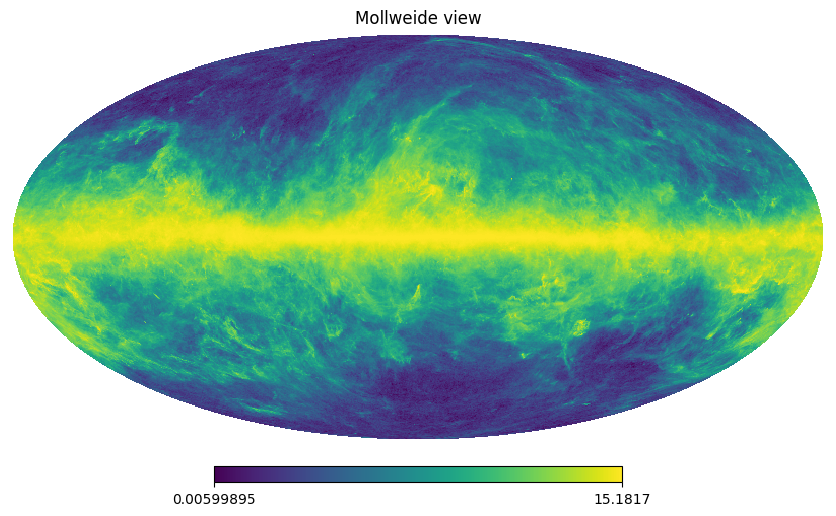

In [135]:
hp.mollview(data["K_CMB Map"][data["Frequency"] == 545].values[0], norm = "hist")

In [137]:
data

,Frequency,FWHM,PSF Map,Mod FWHM,Smooth Map,Degraded Map,K_CMB Map
0,100.0,9.682,"[-0.00012238526, -9.958545e-05, -3.9736184e-05...",2.501775,"[-0.00010362261627242964, -9.304001843116826e-...","[-0.00011166872697597953, -6.739701333126776e-...","[-0.00011166872697597953, -6.739701333126776e-..."
1,143.0,7.303,"[-9.868725e-05, -7.245516e-05, -7.861525e-05, ...",6.831266,"[-9.20367638665555e-05, -6.968037307331415e-05...","[-0.00010190161160085197, -4.5524963778931716e...","[-0.00010190161160085197, -4.5524963778931716e..."
2,217.0,5.021,"[-5.005044e-05, -2.8069558e-06, 1.2417856e-05,...",8.648096,"[-2.711068510696487e-05, -1.533209432198865e-0...","[-4.18147945553166e-05, 1.9249772073472454e-05...","[-4.18147945553166e-05, 1.9249772073472454e-05..."
3,353.0,4.944,"[0.00039311356, 0.00031349497, 0.00053247873, ...",8.692345,"[0.0004330227201937817, 0.0004511297351335562,...","[0.0004353593728396761, 0.00047781326454553554...","[0.0004353593728396761, 0.00047781326454553554..."
4,545.0,4.831,"[0.4312183, 0.4332836, 0.4331446, 0.48448372, ...",8.755652,"[0.42304801838790107, 0.420341867374876, 0.421...","[0.4277199791901232, 0.4256782380269807, 0.426...","[0.007369400054964218, 0.007334221881925925, 0..."
5,857.0,4.638,"[0.890403, 0.8909181, 0.89945364, 0.87775695, ...",8.859399,"[0.8388783804171833, 0.8357292564921366, 0.834...","[0.8490720426092248, 0.8482564790450076, 0.841...","[0.3740405474049448, 0.37368126830176546, 0.37..."
